# _Exploratory Data Analysis of the Coimbra Breast Cancer data Data Set._

## Dataset Summary.

The dataset used in this project consists of anthropometric data and parameters gathered in a standard blood analysis. This dataset was created by Miguel Patrício, José Pereira, Joana Crisóstomo, Paulo Matafome, Raquel Seiça, Francisco Caramelo, all from the Faculty of Medicine of the University of Coimbra and also Manuel Gomes from the University Hospital Centre of Coimbra (Patrício et al., 2018). The dataset was sourced from the UCI Machine Learning Repository (Dua and Graff 2017) and it can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra), particularly [this file](https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv). Each row in this dataset represents a set of observations of individual patients and each column represents a variable. In this dataset, there are 116 observations and 9 features which are all numerical. There are zero observations with missing values for each class in the dataset. The target column is a binary dependent variable, which indicates the presence (Classification = 2) or absence (Classification = 1) of breast cancer.


### Exploratory Data Analysis checklist:

- Formulate the question
- Read in the data
- Check the packaging
- Look at the top and the bottom of your data
- Make a plot
- Follow up

### Formulate the Question: 

Given the clinical and anthropometric data available, predict if a patient have breast cancer or not?

## Load Required Packages

In [1]:
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import pandas as pd
import seaborn as sns

# Classifiers 
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

# Feature and model selection metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)

# Preprocessing and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    StandardScaler,
    normalize,
    scale,
)

## Read in the data and Check the packaging

In [2]:
bc_df = pd.read_csv("../data/raw/dataR2.csv")

bc_df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


### The Workflow to which we should adhere.

To avoid breaking the golden rule and hence optaining an optimistic estimate of our model's performance when computing scores (which is bad), we have decided to split our dataset before performing an exploratory data analysis.

In [3]:
train_df, test_df = train_test_split(bc_df, test_size = 0.2, random_state = 123)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 31 to 109
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             92 non-null     int64  
 1   BMI             92 non-null     float64
 2   Glucose         92 non-null     int64  
 3   Insulin         92 non-null     float64
 4   HOMA            92 non-null     float64
 5   Leptin          92 non-null     float64
 6   Adiponectin     92 non-null     float64
 7   Resistin        92 non-null     float64
 8   MCP.1           92 non-null     float64
 9   Classification  92 non-null     int64  
dtypes: float64(7), int64(3)
memory usage: 7.9 KB


In [5]:
train_df.describe(include = "all")

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,57.717391,27.848295,98.369565,10.033141,2.735269,27.802562,10.266353,15.266048,525.544989,1.543478
std,16.213091,4.961696,23.561338,10.083254,3.796930,19.693162,6.846473,13.479948,346.158574,0.500835
min,25.000000,18.370000,60.000000,2.432000,0.519184,4.311000,1.656020,3.210000,63.610000,1.000000
25%,45.000000,23.286168,85.750000,4.409000,0.993861,13.575000,5.474282,6.704370,269.664000,1.000000
50%,58.000000,27.694389,93.000000,6.036000,1.380939,20.830850,8.408302,11.527485,435.285000,2.000000
75%,69.500000,31.299135,102.250000,11.189250,2.857787,38.083900,12.254740,18.018830,666.233250,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


## Make Plots:

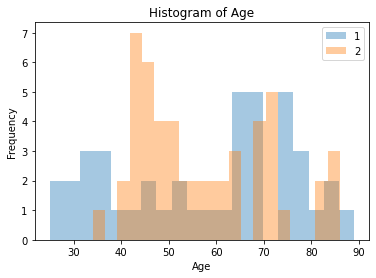

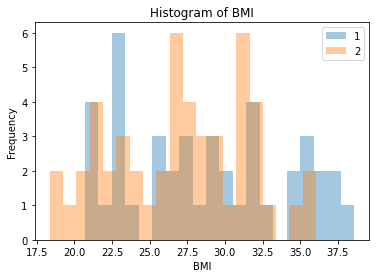

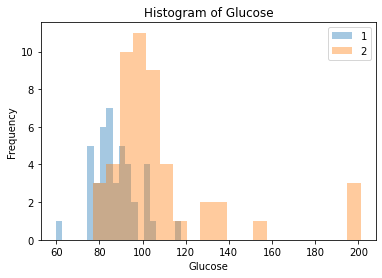

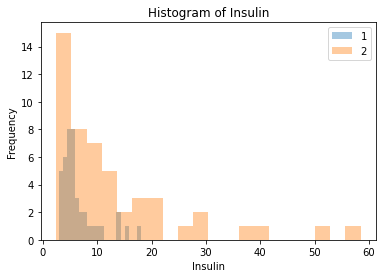

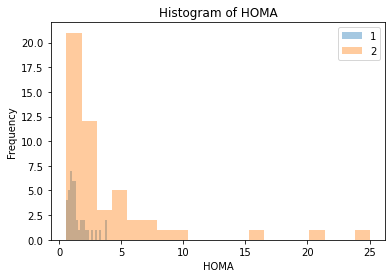

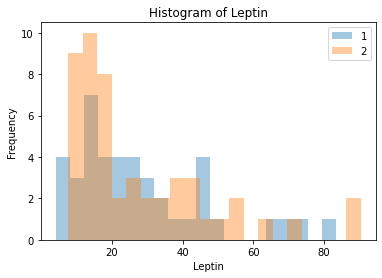

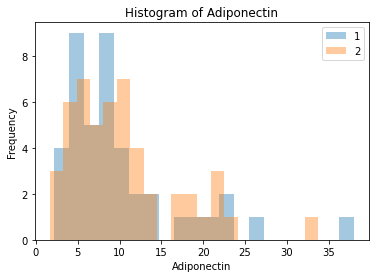

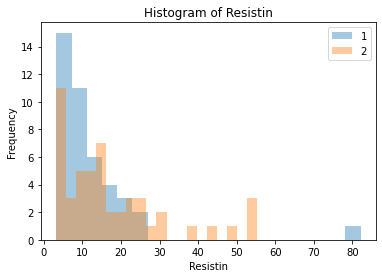

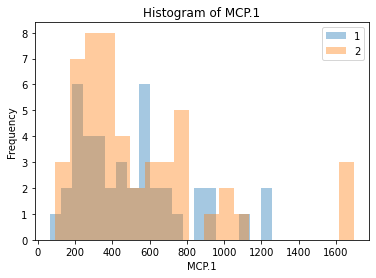

In [6]:
features = train_df.drop(columns = ["Classification"]).select_dtypes(include = np.number)

for feat in features:
    eda_fig = plt.gcf()
    ax = train_df.groupby("Classification")[feat].plot.hist(bins = 20, alpha = 0.4, legend = True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

## Follow up:

Looking at the graphs developed above, there seems to be some interesting features (such as Glucose, Insulin, HOMA, and Resistin) which can be used to predict the presence or absence of breast cancer. Therefore, we plan on exploring classification evaluation metrics, developing a baseline model, exploring more complicated models, choosing a model based on our evaluation metrics, and performing hyperparameter optimization of the model.  

# Analysis 



In [7]:
X_train, y_train = train_df.drop(columns=["Classification"]), train_df["Classification"]

X_test, y_test = test_df.drop(columns=["Classification"]), test_df["Classification"]

In [8]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

numeric_features

['Age',
 'BMI',
 'Glucose',
 'Insulin',
 'HOMA',
 'Leptin',
 'Adiponectin',
 'Resistin',
 'MCP.1']

In [9]:
X_train = train_df.drop(columns = ["Classification"])
y_train = train_df["Classification"]


X_test = test_df.drop(columns = ["Classification"])
y_test = test_df["Classification"]

# Data Preprocessing

Given that we only have numerical features and provided that there are no missing values, therefore, we decided to create a machine learning pipeline that only scales the numerical features, so that we can get appropriate results.

In [10]:
# Since there is no missing values we do not need impute the data
numeric_transformer = make_pipeline(StandardScaler())   

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features)
)

preprocessor.fit(X_train);             # Calling fit to examine all the transformers
preprocessor.named_transformers_

{'pipeline': Pipeline(steps=[('standardscaler', StandardScaler())])}

In [11]:
preprocessor.fit(X_train, y_train);

## Fitting a baseline model and Multiple models

We decided to fit a baseline model to give us an idea of what a minimum score would look like. Furthermore, we attempted to fit different classifiers to observe how they perform on the data.

In [12]:
classifiers = {
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "Decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
}

In [13]:
results_dict = {}
results = {}

scoring = ['recall', 'accuracy', 'precision', 'f1']

for name, classifier in classifiers.items():
    pipe_classifier = make_pipeline(preprocessor, classifier)
    scores = cross_validate(pipe_classifier, X_train, y_train, return_train_score = True, scoring = scoring)
    results = {name: pd.DataFrame(scores).mean().tolist()}
    results_dict.update(results)
    
pd.DataFrame(results_dict, index = scores.keys()).round(4).T

/Users/ifyanene/opt/miniconda3/envs/571/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ifyanene/opt/miniconda3/envs/571/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ifyanene/opt/miniconda3/envs/571/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ifyanene/opt/miniconda3/envs/571/lib

,fit_time,score_time,test_recall,train_recall,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1
DummyClassifier,0.0061,0.0061,0.0000,0.0000,0.5439,0.5435,0.0000,0.0000,0.0000,0.0000
Decision tree,0.0059,0.0047,0.6444,1.0000,0.7281,1.0000,0.7352,1.0000,0.6801,1.0000
kNN,0.0053,0.0058,0.7444,0.8569,0.7076,0.8452,0.6588,0.8157,0.6921,0.8347
RBF SVM,0.0054,0.0046,0.7194,0.8988,0.6965,0.8858,0.6529,0.8591,0.6746,0.8777
Logistic Regression,0.0090,0.0057,0.7917,0.8692,0.7614,0.8234,0.7156,0.7731,0.7410,0.8178
Random Forest,0.1270,0.0130,0.7639,1.0000,0.8047,1.0000,0.8040,1.0000,0.7803,1.0000


## Analysis and Results

The problem statement attempts to predict the presence or absence of breast cancer given the clinical and anthropometric data available. Based on this, we are trying to reduce the amount of false negatives that our model predicts (i.e we care more about accurately predicting the presence of breast cancer), therefore an important evaluation metric is the recall score. Analysing the table above, we can see that the dummy classifier model has the lowest recall scores (0) therefore we can completely ignore this model. Looking at the scores of the decision tree classifier, it has a high train scores for recall, accuracy and f1, however, it has much lower validation ("test") scores, this is indicative of overfitting on the training data, hence, we can eliminate this classifier. The Random Forest classifier can also be discarded using an analysis equivalent to the one used in discarding the Decision Tree classifier (i.e really high train scores, much lower validation ("test") scores).

Furthermore, the kNearest neighbours classifier, Support Vector Machine (SVM) using the Radial Basis Function (RBF) kernel and the logistic regression classifier have similar train and validation scores, however, it is observed that the fundamental tradeoff (i.e the difference between the train and validation errors as train score increases) is minimal when considering the Logistic regression classifier. The logistic regression classifier also has the highest validation f1 ("test_f1") score. This is an extremely promising classifier! Moreover, further down the line we might attempt to optimise the hyperparameters of the classifier chosen thus, the f1 score is also important because it gives us a score to use when optimizing the hyperparameters and it also combines both the recall and precision scores.

Finally, predicated on the aforementioned analysis, the logistic regression is the optimum model chosen to solve this question. 

# _References_

Patrício, M., Pereira, J., Crisóstomo, J., Matafome, P., Gomes, M., Seiça, R. and Caramelo, F., 2018. Using Resistin, glucose, age and BMI to predict the presence of breast cancer. BMC Cancer, 18(1). https://doi.org/10.1186/s12885-017-3877-1

Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.